## Visual Comparison of `RobustFit` and `scikit-learn` for Robust Regression
### Tomasz Janus – <span style="color:#6f2c91;">University of Manchester</span>  & <span style="color:#a71930;">De Montfort University</span> - United Kingdom

---
**Python Package Requirements:**
- `numpy`
- `scikit-learn`
- `matplotlib`
- `clr_loader`
- `pythonnet`
- `rich`

**NOTE:** (`clr_loader` and `pythonnet` are required for executing **.NET** applications within **Python**)

In [1]:
# Python imports
import os
import warnings
import sys
import numpy as np
from sklearn.linear_model import LinearRegression, HuberRegressor
import matplotlib.pyplot as plt
import clr_loader
from pythonnet import set_runtime
rt = clr_loader.get_coreclr()
try: # conditional runtime setting in case runtime has already been loaded
    set_runtime(rt)
except RuntimeError: # if already loaded, do nothing
    pass
import clr
from rich import print as rprint

# RobustFit .NET imports
dll_dir = os.path.abspath("src/RobustFit.Core/bin/Debug/net8.0")
sys.path.append(dll_dir)
# Reference the assembly
clr.AddReference("RobustFit.Core")
# Import and use your class
from RobustFit.Core.Models import OLSRegressor, RobustRegressor
from RobustFit.Core.LossFunctions import HuberLoss, TukeyLoss

In [36]:
# ================= HELPER FUNCTIONS =================
from sklearn.linear_model import LinearRegression, HuberRegressor

# --- Robust Regression: Tukey Loss via IRLS ---
def tukey_weights(residuals, c=4.685):
    """Compute Tukey's biweight weights"""
    r = residuals / c
    w = (1 - r**2)**2
    w[np.abs(r) > 1] = 0
    return w

def robust_tukey_regression(X, y, max_iter=50, tol=1e-6, c=4.685, initial_estimate='ols'):
    """
    Tukey's bisquare robust regression using Iteratively Reweighted Least Squares (IRLS).
    
    Parameters:
    -----------
    X : array-like, shape (n_samples, n_features)
        Input features
    y : array-like, shape (n_samples,)
        Target values
    max_iter : int, default=50
        Maximum number of iterations
    tol : float, default=1e-6
        Convergence tolerance
    c : float, default=4.685
        Tuning constant for Tukey's bisquare function (ensures 95% efficiency)
    initial_estimate : str, default='ols'
        Initial estimate method ('ols' or 'median')
    
    Returns:
    --------
    dict : Dictionary containing:
        - 'coefficients': array of coefficients (intercept + features)
        - 'converged': bool indicating if algorithm converged
        - 'iterations': number of iterations used
        - 'residuals': final residuals
        - 'weights': final weights
    """
    
    # Input validation
    X = np.asarray(X)
    y = np.asarray(y)
    
    if X.ndim != 2:
        raise ValueError("X must be a 2D array")
    if y.ndim != 1:
        raise ValueError("y must be a 1D array")
    if X.shape[0] != y.shape[0]:
        raise ValueError("X and y must have the same number of samples")
    
    n_samples, n_features = X.shape
    
    # Add intercept term
    X_aug = np.hstack([np.ones((n_samples, 1)), X])
    
    # Initial estimate
    if initial_estimate == 'ols':
        try:
            beta = np.linalg.lstsq(X_aug, y, rcond=None)[0]
        except np.linalg.LinAlgError:
            # Fallback to pseudoinverse if lstsq fails
            beta = np.linalg.pinv(X_aug) @ y
    elif initial_estimate == 'median':
        # Simple median-based initial estimate
        beta = np.zeros(n_features + 1)
        beta[0] = np.median(y)  # Intercept as median of y
    else:
        beta = np.zeros(n_features + 1)
    
    converged = False
    
    for iteration in range(max_iter):
        # Predicted values and residuals
        y_pred = X_aug @ beta
        residuals = y - y_pred
        
        # Robust scale estimate using MAD
        mad = np.median(np.abs(residuals - np.median(residuals)))
        
        # Handle edge case where all residuals are identical
        if mad < 1e-12:
            mad = np.std(residuals)  # Fallback to standard deviation
            if mad < 1e-12:
                mad = 1e-6  # Ultimate fallback
        
        # Scale factor (1.4826 makes MAD consistent estimator for normal distribution)
        scale = 1.4826 * mad
        
        # Standardized residuals
        if scale > 0:
            standardized_residuals = residuals / scale
        else:
            standardized_residuals = residuals / 1e-6
        
        # Tukey's bisquare weights
        abs_std_resid = np.abs(standardized_residuals)
        weights = np.where(
            abs_std_resid <= c,
            (1 - (standardized_residuals / c)**2)**2,
            0.0
        )
        
        # Check for numerical issues
        if np.sum(weights) < 1e-12:
            warnings.warn("All weights became zero. Algorithm may not converge properly.")
            break
        
        # Weighted least squares update
        W = np.diag(weights)
        XTW = X_aug.T @ W
        
        try:
            # Use Cholesky decomposition for better numerical stability
            XTWX = XTW @ X_aug
            
            # Add small regularization if matrix is singular
            if np.linalg.cond(XTWX) > 1e12:
                XTWX += np.eye(XTWX.shape[0]) * 1e-12
            
            # Solve the weighted normal equations
            beta_new = np.linalg.solve(XTWX, XTW @ y)
            
        except (np.linalg.LinAlgError, np.linalg.linalg.LinAlgError):
            # Fallback to pseudoinverse
            try:
                beta_new = np.linalg.pinv(XTW @ X_aug) @ (XTW @ y)
            except np.linalg.LinAlgError:
                warnings.warn("Matrix inversion failed. Stopping iterations.")
                break
        
        # Check convergence
        if np.linalg.norm(beta_new - beta) < tol:
            converged = True
            break
        
        beta = beta_new
    
    # Final residuals and weights
    y_pred = X_aug @ beta
    final_residuals = y - y_pred
    mad = np.median(np.abs(final_residuals - np.median(final_residuals)))
    scale = 1.4826 * max(mad, 1e-12)
    standardized_residuals = final_residuals / scale
    final_weights = np.where(
        np.abs(standardized_residuals) <= c,
        (1 - (standardized_residuals / c)**2)**2,
        0.0
    )    
    return {
        'coefficients': beta,
        'converged': converged,
        'iterations': iteration + 1,
        'residuals': final_residuals,
        'weights': final_weights,
        'scale': scale
    }

### 1. Comparison of results using 2D linear regression with outliers

#### Uses data following a simple linear equation $y = 3x + 3y + 1$ with a single outlier and no noise

In [4]:
# Sample data
X = np.array([[1.0, 1.0],
              [2.0, 1.0],
              [1.0, 2.0],
              [2.0, 2.0],
              [3.0, 1.0],
              [1.0, 4.0]])
y = np.array([7.0, 10.0, 10.0, 13.0, 50.0, 16.0])

# --- Ordinary Linear Regression ---
lr = LinearRegression()
lr.fit(X, y)
rprint("[bold blue]Ordinary Linear Regression[/] - [bold]scikitlearn[/]")
print(f'Intercept: {lr.intercept_}')
print(f'Coefficients: {lr.coef_}')
for point, target in zip(X, y):
    pred = lr.intercept_ + np.dot(lr.coef_, point)
    print(f'({point[0]}, {point[1]}) -> pred: {pred:.2f}, actual: {target}, diff: {abs(pred-target):.2f}')

lr_RobustFit = OLSRegressor()
lr_RobustFit.Fit(X, y)
rprint("[bold blue3]Ordinary Linear Regression[/] - [bold]RobustFit[/]")
lr_RobustFit_coeffs = np.array(lr_RobustFit.Coefficients, dtype=float)
print(f'Intercept: {lr_RobustFit_coeffs[0]}')
print(f'Coefficients: {lr_RobustFit_coeffs[1:]}')
for point, target in zip(X, y):
    pred = lr_RobustFit_coeffs[0] + np.dot(lr_RobustFit_coeffs[1:], point)
    print(f'({point[0]}, {point[1]}) -> pred: {pred:.2f}, actual: {target}, diff: {abs(pred-target):.2f}')

rprint('-----------------------------------------------------')

# --- Robust Regression: Huber Loss ---
huber = HuberRegressor(alpha=0.2, epsilon=1.0, max_iter=1_000)
huber.fit(X, y)
rprint("\n[bold green]Huber Loss Regression[/] - [bold]scikitlearn[/]")
print(f'Intercept: {huber.intercept_}')
print(f'Coefficients: {huber.coef_}')
for point, target in zip(X, y):
    pred = huber.intercept_ + np.dot(huber.coef_, point)
    print(f'({point[0]}, {point[1]}) -> pred: {pred:.2f}, actual: {target}, diff: {abs(pred-target):.2f}')

huberLoss = HuberLoss(c=0.2);
huber_RobustFit = RobustRegressor();
huber_RobustFit.Fit(X, y, huberLoss, alpha=0.6, maxIter=1_000, tol=1e-8);
rprint("\n[bold green4]Huber Loss Regression[/] - [bold]RobustFit[/]")
huber_RobustFit_coeffs = np.array(huber_RobustFit.Coefficients, dtype=float)
print(f'Intercept: {huber_RobustFit_coeffs[0]}')
print(f'Coefficients: {huber_RobustFit_coeffs[1:]}')
for point, target in zip(X, y):
    pred = huber_RobustFit_coeffs[0] + np.dot(huber_RobustFit_coeffs[1:], point)
    print(f'({point[0]}, {point[1]}) -> pred: {pred:.2f}, actual: {target}, diff: {abs(pred-target):.2f}')

rprint('-----------------------------------------------------')
    
beta_tukey = robust_tukey_regression(X, y, c=0.685)['coefficients']
intercept, coef = beta_tukey[0], beta_tukey[1:]
rprint("\n[bold magenta]Tukey Loss Regression[/] - [bold]scikitlearn[/]")
print(f'Intercept: {intercept}')
print(f'Coefficients: {coef}')
for point, target in zip(X, y):
    pred = intercept + np.dot(coef, point)
    print(f'({point[0]}, {point[1]}) -> pred: {pred:.2f}, actual: {target}, diff: {abs(pred-target):.2f}')
    
tukeyLoss = TukeyLoss(c = 1.685)
tukey_RobustFit = RobustRegressor()
tukey_RobustFit.Fit(X, y, tukeyLoss, alpha=0.2, maxIter=1_000, tol=1e-8);
rprint("\n[bold magenta3]Tukey Loss Regression[/] - [bold]RobustFit[/]")
tukey_RobustFit_coeffs = np.array(tukey_RobustFit.Coefficients, dtype=float)
print(f'Intercept: {tukey_RobustFit_coeffs[0]}')
print(f'Coefficients: {tukey_RobustFit_coeffs[1:]}')
for point, target in zip(X, y):
    pred = tukey_RobustFit_coeffs[0] + np.dot(tukey_RobustFit_coeffs[1:], point)
    print(f'({point[0]}, {point[1]}) -> pred: {pred:.2f}, actual: {target}, diff: {abs(pred-target):.2f}')

Ordinary Linear Regression - scikitlearn

Intercept: -19.634615384615383
Coefficients: [18.29807692  3.71153846]
(1.0, 1.0) -> pred: 2.38, actual: 7.0, diff: 4.62
(2.0, 1.0) -> pred: 20.67, actual: 10.0, diff: 10.67
(1.0, 2.0) -> pred: 6.09, actual: 10.0, diff: 3.91
(2.0, 2.0) -> pred: 24.38, actual: 13.0, diff: 11.38
(3.0, 1.0) -> pred: 38.97, actual: 50.0, diff: 11.03
(1.0, 4.0) -> pred: 13.51, actual: 16.0, diff: 2.49


Ordinary Linear Regression - RobustFit

Intercept: -19.63461538461539
Coefficients: [18.29807692  3.71153846]
(1.0, 1.0) -> pred: 2.38, actual: 7.0, diff: 4.62
(2.0, 1.0) -> pred: 20.67, actual: 10.0, diff: 10.67
(1.0, 2.0) -> pred: 6.09, actual: 10.0, diff: 3.91
(2.0, 2.0) -> pred: 24.38, actual: 13.0, diff: 11.38
(3.0, 1.0) -> pred: 38.97, actual: 50.0, diff: 11.03
(1.0, 4.0) -> pred: 13.51, actual: 16.0, diff: 2.49


-----------------------------------------------------

Huber Loss Regression - scikitlearn

Intercept: 1.371322590843423
Coefficients: [2.84300381 2.9464184 ]
(1.0, 1.0) -> pred: 7.16, actual: 7.0, diff: 0.16
(2.0, 1.0) -> pred: 10.00, actual: 10.0, diff: 0.00
(1.0, 2.0) -> pred: 10.11, actual: 10.0, diff: 0.11
(2.0, 2.0) -> pred: 12.95, actual: 13.0, diff: 0.05
(3.0, 1.0) -> pred: 12.85, actual: 50.0, diff: 37.15
(1.0, 4.0) -> pred: 16.00, actual: 16.0, diff: 0.00


Huber Loss Regression - RobustFit

Intercept: 1.4937167823307396
Coefficients: [2.57546317 2.84589977]
(1.0, 1.0) -> pred: 6.92, actual: 7.0, diff: 0.08
(2.0, 1.0) -> pred: 9.49, actual: 10.0, diff: 0.51
(1.0, 2.0) -> pred: 9.76, actual: 10.0, diff: 0.24
(2.0, 2.0) -> pred: 12.34, actual: 13.0, diff: 0.66
(3.0, 1.0) -> pred: 12.07, actual: 50.0, diff: 37.93
(1.0, 4.0) -> pred: 15.45, actual: 16.0, diff: 0.55


-----------------------------------------------------

Tukey Loss Regression - scikitlearn

Intercept: 1.999111900531356
Coefficients: [2.0008881 3.       ]
(1.0, 1.0) -> pred: 7.00, actual: 7.0, diff: 0.00
(2.0, 1.0) -> pred: 9.00, actual: 10.0, diff: 1.00
(1.0, 2.0) -> pred: 10.00, actual: 10.0, diff: 0.00
(2.0, 2.0) -> pred: 12.00, actual: 13.0, diff: 1.00
(3.0, 1.0) -> pred: 11.00, actual: 50.0, diff: 39.00
(1.0, 4.0) -> pred: 16.00, actual: 16.0, diff: 0.00


Tukey Loss Regression - RobustFit

Intercept: 1.3553406443801963
Coefficients: [2.74510672 2.95779729]
(1.0, 1.0) -> pred: 7.06, actual: 7.0, diff: 0.06
(2.0, 1.0) -> pred: 9.80, actual: 10.0, diff: 0.20
(1.0, 2.0) -> pred: 10.02, actual: 10.0, diff: 0.02
(2.0, 2.0) -> pred: 12.76, actual: 13.0, diff: 0.24
(3.0, 1.0) -> pred: 12.55, actual: 50.0, diff: 37.45
(1.0, 4.0) -> pred: 15.93, actual: 16.0, diff: 0.07


### 2. Comparison of results using 1D linear regression with outliers

Ordinary Linear Regression - scikit-learn

Intercept: -5.82
Coefficient: 4.56


Ordinary Linear Regression - RobustFit

Intercept: -5.82
Coefficient: 4.56


-------------------------------------------------

Huber Loss Regression - scikit-learn

Intercept: 6.44
Coefficient: 2.09


Huber Loss Regression - RobustFit

Intercept: 6.16
Coefficient: 2.15


-------------------------------------------------

Tukey Loss Regression - Python

Intercept: 8.20
Coefficient: 1.76


Tukey Loss Regression - RobustFit

Intercept: 8.20
Coefficient: 1.76


-------------------------------------------------

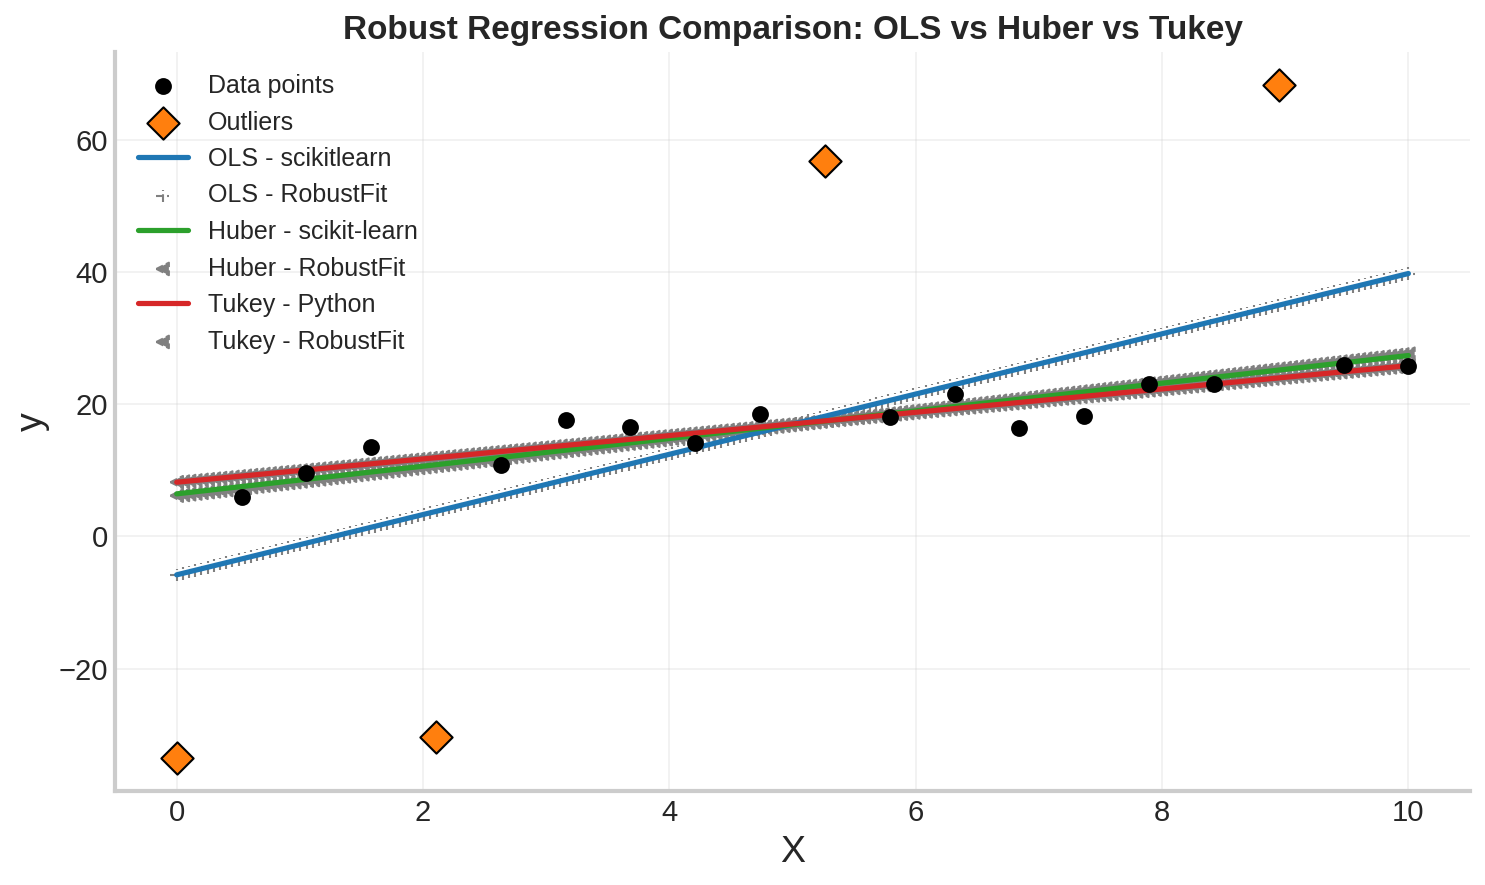

In [38]:
# --- Sample 2D data (more points) ---
np.random.seed(42)
X = np.linspace(0, 10, 20).reshape(-1, 1)
y = 2.5 * X.flatten() + 5 + np.random.randn(20) * 3

# Add outliers
y[[10, 17]] += 40  # positive outliers
y[[0, 4]] -= 40    # negative outliers
outlier_indices = [0, 4, 10, 17]

# --- Ordinary Linear Regression in scikit-learn ---
lr = LinearRegression()
lr.fit(X, y)
rprint("[bold blue]Ordinary Linear Regression[/] - [bold]scikit-learn[/]")
print(f'Intercept: {lr.intercept_:.2f}')
print(f'Coefficient: {lr.coef_[0]:.2f}')

# --- Ordinary Linear Regression in RobustFit ---
lr_RobustFit = OLSRegressor()
lr_RobustFit.Fit(X, y)
rprint("[bold blue3]Ordinary Linear Regression[/] - [bold]RobustFit[/]")
lr_RobustFit_coeffs = np.array(lr_RobustFit.Coefficients, dtype=float)
print(f'Intercept: {lr_RobustFit_coeffs[0]:.2f}')
print(f'Coefficient: {lr_RobustFit_coeffs[1]:.2f}')

rprint('-------------------------------------------------')

# --- Huber Loss Regression ---
huber = HuberRegressor(alpha=0.0, epsilon=1.35, max_iter=1000)
huber.fit(X, y)
rprint("\n[bold green]Huber Loss Regression[/] - [bold]scikit-learn[/]")
print(f'Intercept: {huber.intercept_:.2f}')
print(f'Coefficient: {huber.coef_[0]:.2f}')

# --- Huber Loss Regression in RobustFit ---
huberLoss = HuberLoss(c=1.35);
huber_RobustFit = RobustRegressor();
huber_RobustFit.Fit(X, y, huberLoss, alpha=0.0, maxIter=1_000, tol=1e-8);
rprint("\n[bold green4]Huber Loss Regression[/] - [bold]RobustFit[/]")
huber_RobustFit_coeffs = np.array(huber_RobustFit.Coefficients, dtype=float)
print(f'Intercept: {huber_RobustFit_coeffs[0]:.2f}')
print(f'Coefficient: {huber_RobustFit_coeffs[1]:.2f}')

rprint('-------------------------------------------------')

# --- Tukey Loss Regression ---

beta_tukey = robust_tukey_regression(X, y)['coefficients']
intercept_tukey, coef_tukey = beta_tukey[0], beta_tukey[1:]
rprint("\n[bold magenta]Tukey Loss Regression[/] - [bold]Python[/]")
print(f'Intercept: {intercept_tukey:.2f}')
print(f'Coefficient: {coef_tukey[0]:.2f}')

# --- Tukey Loss Regression in RobustFit ---
tukeyLoss = TukeyLoss(c = 4.685)
tukey_RobustFit = RobustRegressor()
tukey_RobustFit.Fit(X, y, tukeyLoss, alpha=0.0, maxIter=1_000, tol=1e-8);
rprint("\n[bold magenta3]Tukey Loss Regression[/] - [bold]RobustFit[/]")
tukey_RobustFit_coeffs = np.array(tukey_RobustFit.Coefficients, dtype=float)
print(f'Intercept: {tukey_RobustFit_coeffs[0]:.2f}')
print(f'Coefficient: {tukey_RobustFit_coeffs[1]:.2f}')

rprint('-------------------------------------------------')

# --- Professional palette ---
colors = {
    'OLS': '#1f77b4',      # muted blue
    'OLS-RobustFit': '#2596be',      # muted blue 2
    'Huber': '#2ca02c',    # muted green
    'Tukey': '#d62728',    # muted red
    'Data': '#000000',     # black
    'Outlier': '#ff7f0e'   # orange
}

# --- Plotting ---
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

# Scatter points
ax.scatter(X, y, color=colors['Data'], s=50, label='Data points', zorder=3)
ax.scatter(X[outlier_indices], y[outlier_indices], color=colors['Outlier'], s=120, 
           edgecolor='k', label='Outliers', zorder=4, marker='D')

# Regression lines
x_fit = np.linspace(0, 10, 200)
ax.plot(
    x_fit, lr.intercept_ + lr.coef_[0]*x_fit, 
    color=colors['OLS'], 
    linewidth=2.5, label='OLS - scikitlearn')
ax.scatter(
    x_fit, lr_RobustFit_coeffs[0] + lr_RobustFit_coeffs[1]*x_fit, 
    color='grey', 
    linestyle = '--',
    marker = '+',
    linewidth=1.0, label='OLS - RobustFit')
ax.plot(
    x_fit, huber.intercept_ + huber.coef_[0]*x_fit, 
    color=colors['Huber'], linewidth=2.5, label='Huber - scikit-learn')
ax.scatter(
    x_fit, huber_RobustFit_coeffs[0] + huber_RobustFit_coeffs[1]*x_fit, 
    color='grey', 
    linestyle = '--',
    marker = '<',
    linewidth=1.0, label='Huber - RobustFit')
ax.plot(
    x_fit, intercept_tukey + coef_tukey[0]*x_fit, 
    color=colors['Tukey'], linewidth=2.5, label='Tukey - Python')
ax.scatter(
    x_fit, tukey_RobustFit_coeffs[0] + tukey_RobustFit_coeffs[1]*x_fit, 
    color='grey', 
    linestyle = '--',
    marker = '<',
    linewidth=1.0, label='Tukey - RobustFit')

# Labels and title
ax.set_xlabel('X', fontsize=18)
ax.set_ylabel('y', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)  # major ticks
ax.tick_params(axis='both', which='minor', labelsize=14)  # minor ticks
ax.set_title('Robust Regression Comparison: OLS vs Huber vs Tukey', fontsize=16, fontweight='bold')

# Make left and bottom axes thicker
ax.spines['left'].set_linewidth(2)   # thicker left spine
ax.spines['bottom'].set_linewidth(2) # thicker bottom spine

# Hide top and right spines (optional, common in professional plots)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


# Grid and legend
ax.grid(True, alpha=0.3)
ax.legend(fontsize=12)
plt.tight_layout()
plt.show()

## END